In [1]:
import random
import pennylane as qml
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import copy
from sklearn.metrics import roc_auc_score
import copy
import time
from typing import Any, Optional, Tuple, Callable
import mne
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Running on ", device)

Running on  cuda


# QCNN Model

Cong, I., Choi, S., & Lukin, M. D. (2019). Quantum convolutional neural networks. _Nature Physics_, 15(12), 1273-1278. DOI:10.1038/s41567-019-0648-8
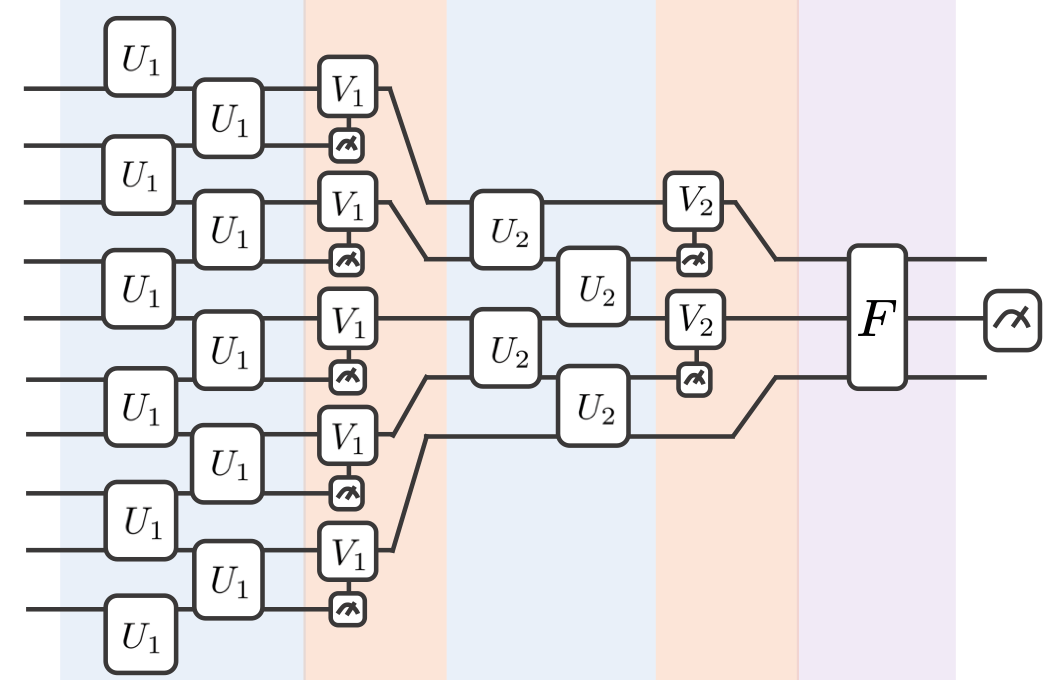

In [2]:
class QCNN(nn.Module):
    def __init__(self, n_qubits=8, circuit_depth=2, input_dim=784):
        """
        QCNN with classical dimensionality reduction and variational embedding.

        Args:
            n_qubits (int): Number of qubits.
            circuit_depth (int): Depth of convolutional layers.
            input_dim (int): Original input data dimensionality (e.g., MNIST image size).
        """
        super(QCNN, self).__init__()

        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth

        # Classical dimension reduction (fully-connected layer)
        self.fc = nn.Linear(input_dim, n_qubits) 
        # self.fc = nn.Sequential(
        #     nn.Linear(input_dim, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, n_qubits)
        # )

        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 18))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))

        # Quantum device initialization
        self.dev = qml.device("default.qubit", wires=n_qubits)

    def circuit(self, conv_weights, pool_weights, features):
        wires = list(range(self.n_qubits))
        
        # Variational Embedding (Angle Embedding)
        qml.AngleEmbedding(features, wires=wires, rotation='Y')

        for layer in range(self.circuit_depth):
            # Convolutional Layer
            self._apply_convolution(conv_weights[layer], wires)
            
            # Pooling Layer
            self._apply_pooling(pool_weights[layer], wires)
            wires = wires[::2]  # Retain every second qubit after pooling
        
        # Measurement
        return qml.expval(qml.PauliZ(wires[0]))

    def forward(self, x):
        # Classical dimension reduction
        reduced_x = self.fc(x)
        
        # Quantum Circuit Execution
        quantum_out = qml.qnode(self.dev, interface="torch")(self.circuit)(
            self.conv_params, self.pool_params, reduced_x
        )

        return quantum_out

    def _apply_convolution(self, weights, wires, skip_first_layer=True):
        """
        Convolutional layer logic (same as original).
        """
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    if indx % 2 == 0 and not skip_first_layer:
                        qml.U3(*weights[indx, :3], wires=w)
                        qml.U3(*weights[indx + 1, :3], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 3], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 4], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 5], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 6:9], wires=w)
                    qml.U3(*weights[indx + 1, 9:12], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        # Pooling using a variational circuit
        n_wires = len(wires)
        assert n_wires >= 2, "Need at least two wires for pooling."
        
        # for indx in range(0, n_wires, 2):
        #     control_wire = wires[indx]
        #     target_wire = wires[indx + 1] if indx + 1 < n_wires else None
        #     if target_wire is not None:
        #         # qml.CRZ(pool_weights[indx // 2, 0], wires=[control_wire, target_wire])
        #         # qml.CRX(pool_weights[indx // 2, 1], wires=[control_wire, target_wire])
        #         # qml.CRY(pool_weights[indx // 2, 2], wires=[control_wire, target_wire])
        #         qml.CNOT(wires=[control_wire, target_wire])

        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

# Preprocess MNIST Dataset

TorchVision MNIST reference: https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html

Original MNIST reference: https://yann.lecun.com/exdb/mnist/

In [3]:
# def load_mnist_binary(seed, n_train, n_valtest, device, batch_size, classes=(0, 1)):
#     # Set random seed for reproducibility
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)

#     # Load dataset with transformation
#     transform = Compose([ToTensor(), lambda x: x.view(-1)])  # Flatten MNIST images
#     data_train = MNIST(root='./data', train=True, download=True, transform=transform)
#     data_test = MNIST(root='./data', train=False, download=True, transform=transform)
#     input_dim = 28 * 28

#     # Filter for binary classes
#     train_mask = (data_train.targets == classes[0]) | (data_train.targets == classes[1])
#     test_mask = (data_test.targets == classes[0]) | (data_test.targets == classes[1])
#     X_train = data_train.data[train_mask].float() / 255.0  # Normalize pixel values to [0, 1]
#     y_train = data_train.targets[train_mask].clone().detach()
#     X_test = data_test.data[test_mask].float() / 255.0
#     y_test = data_test.targets[test_mask].clone().detach()

#     # Binarize labels
#     y_train = (y_train == classes[1]).long()
#     y_test = (y_test == classes[1]).long()

#     # Shuffle data
#     shuffle_idx = torch.randperm(len(y_train))
#     X_train = X_train[shuffle_idx]
#     y_train = y_train[shuffle_idx]

#     shuffle_idx2 = torch.randperm(len(y_test))
#     X_test = X_test[shuffle_idx2]
#     y_test = y_test[shuffle_idx2]

#     # Limit dataset size
#     X_train = X_train[:n_train]
#     y_train = y_train[:n_train]
#     X_test = X_test[:n_valtest]
#     y_test = y_test[:n_valtest]    

#     # Flatten images
#     X_train = X_train.view(-1, 28*28)
#     X_test = X_test.view(-1, 28*28)

#     # Create TensorDatasets
#     train_X = X_train.to(device)
#     train_y = y_train.to(device)
#     test_X = X_test.to(device)
#     test_y = y_test.to(device)

#     train_dataset = TensorDataset(train_X, train_y)
#     valtest_dataset = TensorDataset(test_X, test_y)

#     # Equally split validation and test sets
#     val_size = int(0.5 * len(valtest_dataset))
#     test_size = len(valtest_dataset) - val_size
#     val_dataset, test_dataset = random_split(valtest_dataset, [val_size, test_size])

#     # DataLoader parameters
#     params = {'shuffle': True, 'batch_size': batch_size} if batch_size > 0 else {'shuffle': True}
#     test_params = {'shuffle': False, 'batch_size': batch_size} if batch_size > 0 else {'shuffle': False}

#     train_loader = DataLoader(train_dataset, **params)
#     val_loader = DataLoader(val_dataset, **test_params)
#     test_loader = DataLoader(test_dataset, **test_params)
    
#     return train_loader, val_loader, test_loader, input_dim

# Prepare PhysioNet EEG Dataset

Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. _IEEE Transactions on Biomedical Engineering_ 51(6):1034-1043, 2004.
https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html

In [4]:
def load_eeg(seed, device, batch_size):
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
    # Load and preprocess the PhysioNet EEG Motor Imagery data
    N_SUBJECT = 50
    IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST = [4, 8, 12]

    # Load data from PhysioNet (example assumes data is downloaded locally)
    physionet_paths = [
        mne.datasets.eegbci.load_data(
            subjects=subj_id,
            runs=IMAGINE_OPEN_CLOSE_LEFT_RIGHT_FIST,
            path="PhysioNet_EEG",
        ) for subj_id in range(1, N_SUBJECT+1)
    ]
    physionet_paths = np.concatenate(physionet_paths)

    # Ensuring that all subjects share same sampling frequency
    # TARGET_SFREQ = 160  # 160 Hz sampling rate
    TARGET_SFREQ = 1.6  # 4 Hz sampling rate

    # Concatenate all loaded raw data
    parts = []
    for path in physionet_paths:
        raw = mne.io.read_raw_edf(
            path,
            preload=True,
            stim_channel='auto',
            verbose='WARNING',
        )
        # Resample raw data to ensure consistent sfreq
        raw.resample(TARGET_SFREQ, npad="auto")
        parts.append(raw)
        
    # Concatenate resampled raw data
    raw = mne.concatenate_raws(parts)

    # Pick EEG channels and extract events
    eeg_channel_inds = mne.pick_types(
        raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads'
    )
    events, _ = mne.events_from_annotations(raw)

    # Epoch the data
    epoched = mne.Epochs(
        raw, events, dict(left=2, right=3), tmin=1, tmax=4.1,
        proj=False, picks=eeg_channel_inds, baseline=None, preload=True
    )

    # Convert data to NumPy arrays
    X = (epoched.get_data() * 1e3).astype(np.float32)  # Convert to millivolts
    y = (epoched.events[:, 2] - 2).astype(np.int64)  # 0: left, 1: right

    # Flatten the time and channel dimensions for input to dense neural network
    X_flat = X.reshape(X.shape[0], -1)

    # Normalize the data (Standardization: mean=0, std=1)
    X_mean = X_flat.mean(axis=0)
    X_std = X_flat.std(axis=0)
    X_flat = (X_flat - X_mean) / (X_std + 1e-6)  # Add epsilon to prevent division by zero
    
    # Train-validation-test split
    X_train, X_temp, y_train, y_temp = train_test_split(X_flat, y, test_size=0.3, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
    
    def MakeTensorDataset(X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
        tensordataset = TensorDataset(X_tensor, y_tensor)
        return tensordataset
    
    # Create datasets and dataloaders
    train_dataset = MakeTensorDataset(X_train, y_train)
    val_dataset = MakeTensorDataset(X_val, y_val)
    test_dataset = MakeTensorDataset(X_test, y_test)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_dim = X_train.shape[1]
    
    return train_loader, val_loader, test_loader, input_dim

# Train & Evaluation Functions

In [5]:
################################# Calculate Running Time ########################################
def epoch_time(start_time: float, end_time: float) -> Tuple[float, float]:
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


################################# Performance & Density Matrices ################################
# Training loop
def train_perf(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_outputs = []
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
        labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Collect labels and outputs for AUROC
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs.detach().cpu().numpy())       
        
    # Calculate train AUROC
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    train_auroc = roc_auc_score(all_labels, all_outputs)
    
    return train_loss / len(dataloader), train_auroc


# Validation/Test loop
def evaluate_perf(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure that data is on the same device (GPU or CPU)
            labels = labels.float()   # Ensure labels are of type float for BCEWithLogitsLoss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Collect labels and outputs for AUROC
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    auroc = roc_auc_score(all_labels, all_outputs)
    
    return running_loss / len(dataloader), auroc

# Load Dataset

In [6]:
# train_loader, val_loader, test_loader, input_dim = load_mnist_binary(seed=2025, n_train=20, n_valtest=80, device=device, batch_size=32)
train_loader, val_loader, test_loader, input_dim = load_eeg(seed=2025, device=device, batch_size=32)

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
2250 matching events found
No baseline correction applied
Using data from preloaded Raw for 2250 events and 6 original time points ...
144 bad epochs dropped


In [7]:
def QuantumCNN_run(n_qubits, circuit_depth, num_epochs):
    print("Running on ", device)
    model = QCNN(n_qubits, circuit_depth, input_dim).to(device)
    # criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    criterion = nn.CrossEntropyLoss()   # Loss function for multi-class classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"QuantumCNN_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

In [8]:
QuantumCNN_run(n_qubits=12, circuit_depth=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [00:00<00:00, 17.04it/s]


Epoch: 01 | Time: 0m 6s
Train Loss: 53.5984, AUC: 0.5993 | Validation Loss: 55.5407, AUC: 0.7319


100%|██████████| 10/10 [00:00<00:00, 17.02it/s]


Epoch: 02 | Time: 0m 5s
Train Loss: 53.0110, AUC: 0.7209 | Validation Loss: 55.1136, AUC: 0.7763


100%|██████████| 10/10 [00:00<00:00, 17.01it/s]


Epoch: 03 | Time: 0m 5s
Train Loss: 52.3576, AUC: 0.7919 | Validation Loss: 54.6514, AUC: 0.8014


100%|██████████| 10/10 [00:00<00:00, 16.95it/s]


Epoch: 04 | Time: 0m 5s
Train Loss: 51.9938, AUC: 0.8171 | Validation Loss: 54.2783, AUC: 0.8228


100%|██████████| 10/10 [00:00<00:00, 17.00it/s]


Epoch: 05 | Time: 0m 6s
Train Loss: 51.3826, AUC: 0.8497 | Validation Loss: 54.0457, AUC: 0.8333


100%|██████████| 10/10 [00:00<00:00, 16.90it/s]


Epoch: 06 | Time: 0m 5s
Train Loss: 51.1695, AUC: 0.8583 | Validation Loss: 54.0500, AUC: 0.8319


100%|██████████| 10/10 [00:00<00:00, 16.56it/s]


Epoch: 07 | Time: 0m 5s
Train Loss: 51.0019, AUC: 0.8619 | Validation Loss: 53.9284, AUC: 0.8325


100%|██████████| 10/10 [00:00<00:00, 16.65it/s]


Epoch: 08 | Time: 0m 5s
Train Loss: 50.9618, AUC: 0.8693 | Validation Loss: 53.7597, AUC: 0.8413


100%|██████████| 10/10 [00:00<00:00, 16.93it/s]


Epoch: 09 | Time: 0m 5s
Train Loss: 50.9102, AUC: 0.8654 | Validation Loss: 53.7901, AUC: 0.8359


100%|██████████| 10/10 [00:00<00:00, 16.93it/s]


Epoch: 10 | Time: 0m 5s
Train Loss: 50.6084, AUC: 0.8778 | Validation Loss: 53.9854, AUC: 0.8204


100%|██████████| 10/10 [00:00<00:00, 16.30it/s]

Test Loss: 52.0771, AUC: 0.8594
Metrics saved to QuantumCNN_performance.csv


(52.077051342518395, 0.859351840724272)

# Classical CNN

In [9]:
import torch
import torch.nn as nn

class ClassicalCNN(nn.Module):
    def __init__(self, hidden_dim=8, depth=2, input_dim=784):
        """
        Classical counterpart of the QCNN model using fully connected, convolutional, and pooling layers.

        Args:
            input_dim (int): Input dimension (784 for MNIST).
            hidden_dim (int): Dimension of the hidden embedding (matching n_qubits in QCNN).
            depth (int): Depth of the convolutional layers (matching QCNN circuit depth).
        """
        super().__init__()

        # Classical dimension reduction (embedding)
        self.fc = nn.Linear(input_dim, hidden_dim)

        # Convolutional and pooling layers
        self.layers = nn.ModuleList()
        current_dim = hidden_dim
        for _ in range(depth):
            conv_pool_block = nn.Sequential(
                nn.Linear(current_dim, current_dim), 
                nn.ReLU(),
                nn.Linear(current_dim, current_dim // 2),
                nn.ReLU()
            )
            self.layers.append(conv_pool_block)
            current_dim = current_dim // 2

        # Final linear layer to get single logit output
        self.final_fc = nn.Linear(current_dim, 1)

    def forward(self, x):
        # Classical dimension reduction
        x = self.fc(x)

        # Convolutional and pooling-like layers
        for layer in self.layers:
            x = layer(x)

        # Final output (single logit)
        x = self.final_fc(x)

        return x.view(-1)

In [10]:
def ClassicalCNN_run(n_qubits, circuit_depth, num_epochs):
    print("Running on ", device)
    model = ClassicalCNN(n_qubits, circuit_depth, input_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4, eps=1e-8)
        
    # Training process
    train_metrics, valid_metrics, test_metrics = [], [], []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_auc = train_perf(model, train_loader, optimizer, criterion)
        train_metrics.append({'epoch': epoch + 1, 'train_loss': train_loss, 'train_auc': train_auc})    
    
        valid_loss, valid_auc = evaluate_perf(model, val_loader, criterion)
        valid_metrics.append({'epoch': epoch + 1, 'valid_loss': valid_loss, 'valid_auc': valid_auc})
    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f} | Validation Loss: {valid_loss:.4f}, AUC: {valid_auc:.4f}")

    # Final evaluation on the test set
    test_loss, test_auc = evaluate_perf(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, AUC: {test_auc:.4f}")
    test_metrics.append({'epoch': num_epochs, 'test_loss': test_loss, 'test_auc': test_auc}) 

    # Combine all metrics into a pandas DataFrame
    metrics = []
    for epoch in range(num_epochs):
        metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_metrics[epoch]['train_loss'],
            'train_auc': train_metrics[epoch]['train_auc'],
            'valid_loss': valid_metrics[epoch]['valid_loss'],
            'valid_auc': valid_metrics[epoch]['valid_auc'],
            'test_loss': test_metrics[0]['test_loss'],
            'test_auc': test_metrics[0]['test_auc'],
        })
    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    # Save to CSV
    csv_filename = f"ClassicalCNN_performance.csv"
    metrics_df.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")
        
    return test_loss, test_auc

In [11]:
ClassicalCNN_run(n_qubits=12, circuit_depth=2, num_epochs=10)

Running on  cuda


100%|██████████| 10/10 [00:00<00:00, 1666.72it/s]


Epoch: 01 | Time: 0m 0s
Train Loss: 0.6869, AUC: 0.6186 | Validation Loss: 0.6759, AUC: 0.7196


100%|██████████| 10/10 [00:00<00:00, 1588.69it/s]


Epoch: 02 | Time: 0m 0s
Train Loss: 0.6599, AUC: 0.7275 | Validation Loss: 0.6459, AUC: 0.7520


100%|██████████| 10/10 [00:00<00:00, 1694.67it/s]


Epoch: 03 | Time: 0m 0s
Train Loss: 0.6129, AUC: 0.7874 | Validation Loss: 0.5939, AUC: 0.8233


100%|██████████| 10/10 [00:00<00:00, 1674.57it/s]


Epoch: 04 | Time: 0m 0s
Train Loss: 0.5647, AUC: 0.8331 | Validation Loss: 0.5601, AUC: 0.8389


100%|██████████| 10/10 [00:00<00:00, 1708.75it/s]


Epoch: 05 | Time: 0m 0s
Train Loss: 0.5414, AUC: 0.8439 | Validation Loss: 0.5438, AUC: 0.8272


100%|██████████| 10/10 [00:00<00:00, 1680.41it/s]


Epoch: 06 | Time: 0m 0s
Train Loss: 0.5317, AUC: 0.8432 | Validation Loss: 0.5465, AUC: 0.8212


100%|██████████| 10/10 [00:00<00:00, 1712.38it/s]


Epoch: 07 | Time: 0m 0s
Train Loss: 0.5015, AUC: 0.8593 | Validation Loss: 0.5378, AUC: 0.8238


100%|██████████| 10/10 [00:00<00:00, 1724.21it/s]


Epoch: 08 | Time: 0m 0s
Train Loss: 0.4857, AUC: 0.8624 | Validation Loss: 0.5257, AUC: 0.8223


100%|██████████| 10/10 [00:00<00:00, 1720.88it/s]


Epoch: 09 | Time: 0m 0s
Train Loss: 0.4694, AUC: 0.8682 | Validation Loss: 0.5208, AUC: 0.8240


100%|██████████| 10/10 [00:00<00:00, 1750.76it/s]


Epoch: 10 | Time: 0m 0s
Train Loss: 0.4626, AUC: 0.8615 | Validation Loss: 0.5792, AUC: 0.8051


100%|██████████| 10/10 [00:00<00:00, 1647.86it/s]

Test Loss: 0.5565, AUC: 0.8413
Metrics saved to ClassicalCNN_performance.csv


(0.5564588636159897, 0.8412851019508873)